<a href="https://colab.research.google.com/github/AgapovDP/inverse-problem-of-GP/blob/main/GPNN_full_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Подготовка к запуску

In [1]:
import numpy as np
import random 
import matplotlib.pyplot as plt
from torch import nn,manual_seed,from_numpy, split, tensor
import torch.optim as optim
import torch
import time
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


set_random_seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


## Загрузка данных

In [3]:
DataNPY = np.load("/content/gdrive/MyDrive/Data_art_NN/Datasets/datasetChoiseClass_700000_[13Feb2023].npy",allow_pickle=True)

In [4]:
class GPDataset(Dataset):
    def __init__(self, GPdata):
      self.nanToken = 10.
      self.GPdata = []
      for obj in tqdm(GPdata):
        self.GPdata.append((tensor(obj[0]),tensor(obj[1]),tensor(obj[2])))
    
    def __len__(self):
      return len(self.GPdata)

    def __getitem__(self, idx):
      return self.GPdata[idx][0],self.GPdata[idx][1],self.GPdata[idx][2]




In [5]:

# Длина обучающей и тестирующей выборок
lenTestData = 100000
lenTrainData = 700000
batch_size = 1000

testDatasets = GPDataset(DataNPY[:lenTestData])
trainDatasets = GPDataset(DataNPY[lenTestData:lenTrainData])

testDataloader = DataLoader(testDatasets, batch_size=batch_size, shuffle=False, num_workers=2)
trainDataloader = DataLoader(trainDatasets, batch_size=batch_size, shuffle=True, num_workers=2)

100%|██████████| 600000/600000 [00:13<00:00, 43722.65it/s]


## Структура модели

In [6]:

# Функция для создания Sequential для выходов
def outputLaeyrs(otput, lenOfFirstLayer = 700,lenOfSecondLayer = 70, nonlinearity = nn.ReLU, mod = 'classifier'):
  seq = nn.Sequential(nn.Linear(lenOfFirstLayer, lenOfSecondLayer, bias=False),
                      nonlinearity(),
                      nn.BatchNorm1d(lenOfSecondLayer),
                      nn.Linear(lenOfSecondLayer, otput))
  if mod == 'classifier':
    seq.append(nn.Sigmoid())
  return seq



# Последовательность для первичной обработки (фактически это embedding)
embSeq_base = nn.Sequential(
     nn.Linear(5, 200, bias=False),
     nn.ReLU(),
     nn.BatchNorm1d(200),
     nn.Linear(200, 2000, bias=False),
     nn.ReLU(),
     nn.BatchNorm1d(2000),
     nn.Linear(2000, 4000, bias=False),
     nn.ReLU(),
     nn.BatchNorm1d(4000),
     nn.Linear(4000, 700, bias=False),
     nn.ReLU(),
     nn.BatchNorm1d(700)
)


regrSeq_base = nn.Sequential(
     nn.Linear(700, 1500, bias=False),
     nn.ReLU(),
     nn.BatchNorm1d(1500),
     nn.Linear(1500, 700, bias=False),
     nn.ReLU(),
     nn.BatchNorm1d(700)
)


In [7]:
class GPNN_v1(nn.Module):
  def __init__(self, SeqEmbedding = embSeq_base, SeqRegression = regrSeq_base, init_form = "normal"):
    super().__init__()
    self.embedding_stack = SeqEmbedding
    self.regression_stack = SeqRegression

    self.classifierLAA = outputLaeyrs(1); self.classifierLPA = outputLaeyrs(1)
    self.classifierCAA = outputLaeyrs(1); self.classifierCPA = outputLaeyrs(1)
    
    #self.regressionT = outputLaeyrs(1, mod = 0)
    self.regressionP = outputLaeyrs(1, mod = 0)
    self.regressionTheta = outputLaeyrs(1, mod = 0) 
    self.regressionDelta = outputLaeyrs(1, mod = 0)
    self.regressionPhi = outputLaeyrs(1, mod = 0)
    self.regressionCAA = outputLaeyrs(1, mod = 0)
    self.regressionCPA = outputLaeyrs(1, mod = 0)

    self.init_form = init_form
    if self.init_form is not None:
      self.init()
            

  def forward(self, x, mod = 'NoTrain', classVectors = np.nan):
    emb = self.embedding_stack(x)
    if mod == 'classifier':
      return self.classifierLAA(emb),self.classifierLPA(emb),\
            self.classifierCAA(emb),self.classifierCPA(emb)

    if mod == 'regression':
      outReg = self.regression_stack(emb)
      return self.regressionP(outReg),self.regressionTheta(outReg),self.regressionDelta(outReg),\
              self.regressionPhi(outReg), self.regressionCAA(outReg), self.regressionCPA(outReg)

    if mod == 'NoTrain':
      outReg = self.regression_stack(emb)
      return self.classifierLAA(emb),self.classifierLPA(emb), self.classifierCAA(emb),\
        self.classifierCPA(emb), self.regressionP(outReg),\
          self.regressionTheta(outReg), self.regressionDelta(outReg), self.regressionPhi(outReg),\
            self.regressionCAA(outReg), self.regressionCPA(outReg)


  
  def init(self):
    relu_gain = torch.nn.init.calculate_gain("relu")
    for child in self.embedding_stack.children():
      if isinstance(child, nn.Linear):
        if self.init_form == "normal":
          torch.nn.init.kaiming_normal_(child.weight, nonlinearity='relu')
          if child.bias is not None: torch.nn.init.zeros_(child.bias)
        elif self.init_form == "uniform":
          torch.nn.init.kaiming_uniform_(child.weight,nonlinearity='relu')
          if child.bias is not None:torch.nn.init.zeros_(child.bias)
        else:
          raise NotImplementedError()

    for child in self.regression_stack.children():
      if isinstance(child, nn.Linear):
        if self.init_form == "normal":
          torch.nn.init.kaiming_normal_(child.weight, nonlinearity='relu')
          if child.bias is not None: torch.nn.init.zeros_(child.bias)
        elif self.init_form == "uniform":
          torch.nn.init.kaiming_uniform_(child.weight,nonlinearity='relu')
          if child.bias is not None:torch.nn.init.zeros_(child.bias)
        else:
          raise NotImplementedError()

## Функции для обучения

In [8]:
def lossClassifierGP(criterion,predict,original):
  criterion = criterion()
  total_loss = criterion(predict[0],original[:,0].reshape(-1,1))+criterion(predict[1],original[:,1].reshape(-1,1))+\
  criterion(predict[2],original[:,2].reshape(-1,1))+criterion(predict[3],original[:,3].reshape(-1,1))
  return total_loss

In [9]:
def accClassifierGP(model,localData,device):
  accLAA,accLPA,accCAA,accCPA =0.,0.,0.,0.
  model.eval()
  with torch.no_grad():
    for corrFunc, classVectors, _ in localData:
      corrFunc, classVectors = corrFunc.to(device), classVectors.to(device)
      predict = model(corrFunc,mod = 'classifier')
      accLAA = accLAA + (predict[0].reshape(-1).detach().round() == classVectors[:,0].detach().round()).to('cpu').numpy().mean()
      accLPA = accLPA + (predict[1].reshape(-1).detach().round() == classVectors[:,1].detach().round()).to('cpu').numpy().mean()
      accCAA = accCAA + (predict[2].reshape(-1).detach().round() == classVectors[:,2].detach().round()).to('cpu').numpy().mean()
      accCPA = accCPA + (predict[3].reshape(-1).detach().round() == classVectors[:,3].detach().round()).to('cpu').numpy().mean()

  localLen = len(localData)
  return accLAA/localLen,accLPA/localLen,accCAA/localLen,accCPA/localLen

In [10]:
def trainGPNNClassifier(model, trainloader,testloader,device = 'cpu', num_epochs = 2, criterion = nn.BCELoss,\
              optimizer = optim.Adam,learning_rate = 0.001):

    
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    num_epochs = num_epochs
    loss_hist_train = [] # for plotting
    loss_hist_test = []
    accTrainLAA,accTrainLPA,accTrainCAA,accTrainCPA = [],[],[],[]
    accTestLAA,accTestLPA,accTestCAA,accTestCPA = [],[],[],[]

    for epoch in tqdm(range(num_epochs)):
        # Обучение

        hist_loss = 0
        model.train()
        for corrFunc, classVectors, _ in trainloader:
            classVectors = classVectors.float()
            corrFunc, classVectors = corrFunc.to(device), classVectors.to(device)
            optimizer.zero_grad()
            loss = lossClassifierGP(criterion, model(corrFunc,mod = 'classifier'), classVectors)
            loss.backward()    
            optimizer.step()
            hist_loss += loss.item()
        loss_hist_train.append(hist_loss /len(trainloader))

        
        
        accLAA,accLPA,accCAA,accCPA = accClassifierGP(model,trainloader,device)
        accTrainLAA.append(accLAA);accTrainLPA.append(accLPA)
        accTrainCAA.append(accCAA);accTrainCPA.append(accCPA)


        # Проверка на тестовых данных
        model.eval()
        test_loss = 0
        numBatch = 0
        with torch.no_grad():
          for corrFunc, classVectors, _ in testloader:
            classVectors = classVectors.float()
            corrFunc, classVectors = corrFunc.to(device), classVectors.to(device)
            loss = lossClassifierGP(criterion, model(corrFunc,mod = 'classifier'), classVectors)
            test_loss += loss.item()
        loss_hist_test.append(test_loss/len(testloader))
        
        accLAA,accLPA,accCAA,accCPA = accClassifierGP(model,testloader,device)
        accTestLAA.append(accLAA);accTestLPA.append(accLPA)
        accTestCAA.append(accCAA);accTestCPA.append(accCPA)

        
        if epoch%9 == 0: print(f"Epoch={epoch} loss_train={loss_hist_train[epoch]:.5f} loss_test={loss_hist_test[epoch]:.5f}")
    
    return loss_hist_train,loss_hist_test,\
      [accTrainLAA,accTrainLPA,accTrainCAA,accTrainCPA],[accTestLAA,accTestLPA,accTestCAA,accTestCPA]

In [11]:
def accRegressor(model,localData,device):
  loss_P, loss_Theta = 0., 0.
  loss_Delta, loss_Phi  = 0., 0.
  loss_CAA, loss_CPA = 0.,0.
  #loss_T = 0.

  model.eval()
  with torch.no_grad():
    for corrFunc, _, parameters in localData:
      corrFunc, parameters = corrFunc.to(device), parameters.to(device)
      predict = model(corrFunc, mod = 'regression')

      #loss_T = loss_T + (abs(predict[0]-parameters[:,0])).mean().item()

      predP = predict[0][~torch.any(torch.unsqueeze(parameters[:,0],1).isnan(),dim=1)]
      paramP = torch.unsqueeze(parameters[:,0],1)[~torch.any(torch.unsqueeze(parameters[:,0],1).isnan(),dim=1)]
      loss_P = loss_P + abs(predP-paramP).mean().item()

      predTheta = predict[1][~torch.any(torch.unsqueeze(parameters[:,1],1).isnan(),dim=1)]
      paramTheta  = torch.unsqueeze(parameters[:,1],1)[~torch.any(torch.unsqueeze(parameters[:,1],1).isnan(),dim=1)]
      loss_Theta = loss_Theta + abs(predTheta-paramTheta).mean().item()

      predDelta = predict[2][~torch.any(torch.unsqueeze(parameters[:,2],1).isnan(),dim=1)]
      paramDelta = torch.unsqueeze(parameters[:,2],1)[~torch.any(torch.unsqueeze(parameters[:,2],1).isnan(),dim=1)]
      loss_Delta = loss_Delta + abs(predDelta-paramDelta).mean().item()

      predPhi = predict[3][~torch.any(torch.unsqueeze(parameters[:,3],1).isnan(),dim=1)]
      paramPhi = torch.unsqueeze(parameters[:,3],1)[~torch.any(torch.unsqueeze(parameters[:,3],1).isnan(),dim=1)]
      loss_Phi = loss_Phi + abs(predPhi-paramPhi).mean().item()

      predCAA = predict[4][~torch.any(torch.unsqueeze(parameters[:,4],1).isnan(),dim=1)].to(device)
      paramCAA = torch.unsqueeze(parameters[:,4],1)[~torch.any(torch.unsqueeze(parameters[:,4],1).isnan(),dim=1)].to(device)

      loss_CAA = loss_CAA + (abs(predCAA-paramCAA)).mean().item()


      predCPA = predict[5][~torch.any(torch.unsqueeze(parameters[:,5],1).isnan(),dim=1)].to(device)
      paramCPA = torch.unsqueeze(parameters[:,5],1)[~torch.any(torch.unsqueeze(parameters[:,5],1).isnan(),dim=1)].to(device)

      loss_CPA = loss_CPA + (abs(predCPA-paramCPA)).mean().item()
    
  return loss_P/len(parameters),loss_Theta/len(parameters),loss_Delta/len(parameters),loss_Phi/len(parameters),\
        loss_CAA/len(parameters),loss_CPA/len(parameters)

In [12]:
def lossRegressionGP(criterion,predict,parameters):
  criterion = criterion()

  predP = predict[0][~torch.any(torch.unsqueeze(parameters[:,0],1).isnan(),dim=1)]
  paramP = torch.unsqueeze(parameters[:,0],1)[~torch.any(torch.unsqueeze(parameters[:,0],1).isnan(),dim=1)]

  predTheta = predict[1][~torch.any(torch.unsqueeze(parameters[:,1],1).isnan(),dim=1)]
  paramTheta  = torch.unsqueeze(parameters[:,1],1)[~torch.any(torch.unsqueeze(parameters[:,1],1).isnan(),dim=1)]
  
  predDelta = predict[2][~torch.any(torch.unsqueeze(parameters[:,2],1).isnan(),dim=1)]
  paramPDelta = torch.unsqueeze(parameters[:,2],1)[~torch.any(torch.unsqueeze(parameters[:,2],1).isnan(),dim=1)]

  predPhi = predict[3][~torch.any(torch.unsqueeze(parameters[:,3],1).isnan(),dim=1)]
  paramPhi = torch.unsqueeze(parameters[:,3],1)[~torch.any(torch.unsqueeze(parameters[:,3],1).isnan(),dim=1)]

  predCAA = predict[4][~torch.any(torch.unsqueeze(parameters[:,4],1).isnan(),dim=1)]
  paramCAA = torch.unsqueeze(parameters[:,4],1)[~torch.any(torch.unsqueeze(parameters[:,4],1).isnan(),dim=1)]

  predCPA = predict[5][~torch.any(torch.unsqueeze(parameters[:,5],1).isnan(),dim=1)]
  paramCPA = torch.unsqueeze(parameters[:,5],1)[~torch.any(torch.unsqueeze(parameters[:,5],1).isnan(),dim=1)]

  total_loss = criterion(predP,paramP) + criterion(predTheta,paramTheta) + \
        criterion(predPhi,paramPhi) + criterion(predDelta,paramPDelta) + \
        criterion(predCAA,paramCAA) + criterion(predCPA,paramCPA) # + criterion(predict[0],torch.unsqueeze(parameters[:,0],1))
  return total_loss

In [13]:
def trainGPNNRegressor(model, trainloader,testloader,device = 'cpu', num_epochs = 2, criterion = nn.MSELoss,\
              optimizer = optim.Adam,learning_rate = 0.001):

    # Замораживаем веса для эмбединга
    for param in model.embedding_stack.parameters():
      param.requires_grad = False
    
      
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    num_epochs = num_epochs
    loss_hist_train = [] # for plotting
    loss_hist_test = []
    accTrainP,accTrainTheta,accTrainPhi,accTrainDelta = [],[],[],[]
    accTestP,accTestTheta,accTestPhi,accTestDelta = [],[],[],[]
    accTrainR, accTrainKsi = [],[]
    accTestR, accTestKsi = [],[]
    accTrainT = []
    accTestT = []

    for epoch in tqdm(range(num_epochs)):
        # Обучение

        hist_loss = 0
        model.train()
        for corrFunc, _, parameters in trainloader:
            corrFunc, parameters = corrFunc.to(device), parameters.to(device)
            optimizer.zero_grad()
            loss = lossRegressionGP(criterion, model(corrFunc,mod = 'regression'), parameters)
            loss.backward()    
            optimizer.step()
            hist_loss += loss.item()
        loss_hist_train.append(hist_loss /len(trainloader))
        
        accP,accTheta,accPhi,accDelta,accR,accKsi = accRegressor(model,trainloader,device)
        accTrainP.append(accP);accTrainTheta.append(accTheta)
        accTrainPhi.append(accPhi);accTrainDelta.append(accDelta)
        accTrainKsi.append(accKsi);accTrainR.append(accR)


        # Проверка на тестовых данных
        model.eval()
        test_loss = 0
        numBatch = 0
        with torch.no_grad():
          for corrFunc, _,parameters in testloader:
            corrFunc, parameters = corrFunc.to(device), parameters.to(device)
            loss = lossRegressionGP(criterion, model(corrFunc,mod = 'regression'), parameters)
            test_loss += loss.item()
        loss_hist_test.append(test_loss/len(testloader))

        accP,accTheta,accPhi,accDelta,accR,accKsi = accRegressor(model,testloader,device)
        accTestP.append(accP);accTestTheta.append(accTheta)
        accTestPhi.append(accPhi);accTestDelta.append(accDelta)
        accTestKsi.append(accKsi);accTestR.append(accR)

        
        if epoch%9 == 0: print(f"Epoch={epoch} loss_train={loss_hist_train[epoch]:.5f} loss_test={loss_hist_test[epoch]:.5f}")
    
    return loss_hist_train,loss_hist_test,\
      [accTrainP,accTrainTheta,accTrainPhi,accTrainDelta,accTrainR,accTrainKsi],\
      [accTestP,accTestTheta,accTestPhi,accTestDelta,accTestR,accTestKsi]

## Обучение

**НУЖНО ОТКЛЧИТЬ БИАС:*!!!!*

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [15]:
set_random_seed(42)

model = GPNN_v1().to(device)
model = model.float()
time_0 = time.time()
loss_train, loss_test, acc_test, acc_train = trainGPNNClassifier(model,trainDataloader, testDataloader,\
                      num_epochs = 15, criterion = nn.L1Loss ,learning_rate = 0.0001, device = device)
print("Duration:", time.time()-time_0)

  7%|▋         | 1/15 [00:14<03:26, 14.75s/it]

Epoch=0 loss_train=0.26315 loss_test=0.11312


 67%|██████▋   | 10/15 [02:00<00:59, 11.84s/it]

Epoch=9 loss_train=0.03710 loss_test=0.04355


100%|██████████| 15/15 [03:00<00:00, 12.00s/it]

Duration: 180.05111384391785


In [16]:

loss_trainR, loss_testR, acc_testR, acc_trainR = trainGPNNRegressor(model,trainDataloader, testDataloader,\
                      num_epochs = 15, learning_rate = 0.0001, device = device)


  7%|▋         | 1/15 [00:16<03:46, 16.20s/it]

Epoch=0 loss_train=0.40307 loss_test=0.22036


 67%|██████▋   | 10/15 [02:42<01:22, 16.45s/it]

Epoch=9 loss_train=0.14687 loss_test=0.13164


100%|██████████| 15/15 [04:04<00:00, 16.29s/it]


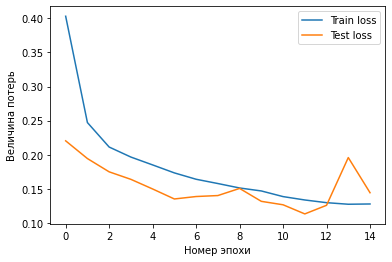

In [17]:
fig, ax = plt.subplots()
ax.plot(loss_trainR, label='Train loss')
ax.plot(loss_testR, label='Test loss')
ax.set_xlabel("Номер эпохи")
ax.set_ylabel("Величина потерь")
ax.legend()

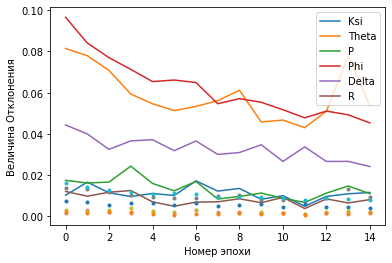

In [18]:
## ТОЧНОСТЬ МОДУЛЯ РЕГРЕССИ
fig, ax = plt.subplots()
ax.plot(acc_testR[5],label='Ksi')
ax.plot(acc_testR[0],label='Theta')
ax.plot(acc_testR[1],label='P')
ax.plot(acc_testR[2],label='Phi')
ax.plot(acc_testR[3],label='Delta')
ax.plot(acc_testR[4],label='R')
#ax.plot(acc_testR[6],label='Ksi')
ax.plot(acc_trainR[5],".")
ax.plot(acc_trainR[0],".")
ax.plot(acc_trainR[1],".")
ax.plot(acc_trainR[2],".")
ax.plot(acc_trainR[3],".")
ax.plot(acc_trainR[4],".")
#ax.plot(acc_trainR[6],".")
ax.set_xlabel("Номер эпохи")
ax.set_ylabel("Величина Отклонения")
ax.legend()

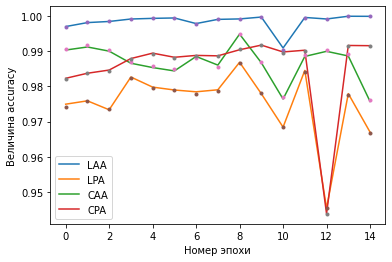

In [19]:
## ТОЧНОСТЬ МОДУЛЯ КЛАССИФИКАТОРА

fig, ax = plt.subplots()
ax.plot(acc_test[0],label='LAA')
ax.plot(acc_test[1],label='LPA')
ax.plot(acc_test[2],label='CAA')
ax.plot(acc_test[3],label='CPA')
ax.plot(acc_train[0],".")
ax.plot(acc_train[1],".")
ax.plot(acc_train[2],".")
ax.plot(acc_train[3],".")
ax.set_xlabel("Номер эпохи")
ax.set_ylabel("Величина accuracy")
ax.legend()
  

## допл

In [22]:

print(model.embedding_stack)

Sequential(
  (0): Linear(in_features=5, out_features=200, bias=False)
  (1): ReLU()
  (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=200, out_features=2000, bias=False)
  (4): ReLU()
  (5): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=2000, out_features=4000, bias=False)
  (7): ReLU()
  (8): BatchNorm1d(4000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=4000, out_features=700, bias=False)
  (10): ReLU()
  (11): BatchNorm1d(700, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
